In [6]:
pip install mxnet gluonts ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [64]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
import yfinance as yf

btc=yf.download(tickers='BTC-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#bitcoin
eth=yf.download(tickers='ETH-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#etherum
bnb=yf.download(tickers='BNB-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#binance

aapl = yf.download(tickers='AAPL', start='2020-01-01', end='2022-11-30', interval = '1d')#apple
tsla=yf.download(tickers='TSLA', start='2020-01-01', end='2022-11-30', interval = '1d')#tesla
googl=yf.download(tickers='GOOGL', start='2020-01-01', end='2022-11-30', interval = '1d')#google
     

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [66]:
def clean_data(data):
  data.reset_index(inplace=True)
  data['Date'] = pd.to_datetime(data['Date'])
  df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
  df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
  return df
     

In [67]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [68]:
def mod_train(df):
  training_data = ListDataset(
    [{"start": df.index[0], "target": df.Close[:"2022-12-01T00:00:00.000000"], }],
    freq = "C"
  )
  callbacks = [
  LearningRateReduction(objective="min",
                        patience=10,
                        base_lr=1e-3,
                        decay_factor=0.5,
                        ),
               ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
               ]
  estimator = DeepAREstimator(
  freq="M",
  prediction_length=24,
  context_length=36,
  num_layers = 2,
  num_cells = 40,
  distr_output=StudentTOutput(),
  dropout_rate=0.01,
  trainer=Trainer(#ctx = mx.context.gpu(),
                  epochs=500,
                  callbacks=callbacks))
  predictor = estimator.train(training_data)
  test_data = ListDataset(
    [{"start": df.index[0], "target": df.Close[:"2022-12-01T00:00:00.000000"]}],
    freq = "D"
    )
  entry = next(iter(test_data))
  test_series = to_pandas(entry)
  test_series.plot()
  plt.axvline(df.index[-24], color='r') # end of train dataset
  plt.grid(which="both")
  plt.legend(["test series", "end of train series"], loc="upper left")
  # plt.title(entry['item_id'])
  plt.show()
  forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
    )

  forecasts = list(forecast_it)
  tss = list(ts_it)
  ts_entry = tss[0]
  forecast_entry = forecasts[0]
  def plot_prob_forecasts(ts_entry, forecast_entry):
      plot_length = 150
      prediction_intervals = (50.0, 90.0)
      legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

      fig, ax = plt.subplots(1, 1, figsize=(10, 7))
      ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
      forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
      plt.grid(which="both")
      plt.legend(legend, loc="upper left")
      plt.show()
  plot_prob_forecasts(ts_entry, forecast_entry)
  evaluator = Evaluator()
  agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

  import json
  print(json.dumps(agg_metrics, indent=4))

100%|██████████| 50/50 [00:05<00:00,  8.68it/s, epoch=500/500, avg_epoch_loss=7.98]


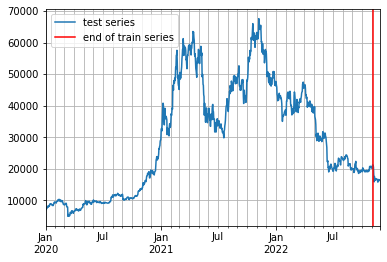

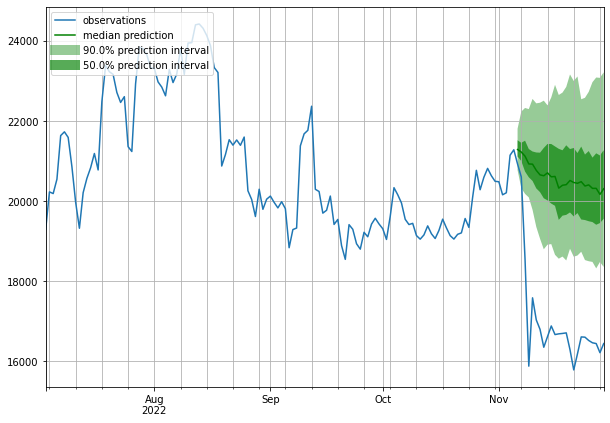

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

{
    "MSE": 14873208.0,
    "abs_error": 86872.4609375,
    "abs_target_sum": 407571.1875,
    "abs_target_mean": 16982.1328125,
    "seasonal_error": 802.9771414821944,
    "MASE": 4.507831774282329,
    "MAPE": 0.21803083022435507,
    "sMAPE": 0.1948503057161967,
    "MSIS": 82.8051409955872,
    "QuantileLoss[0.1]": 102758.262890625,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.2]": 107502.76250000001,
    "Coverage[0.2]": 1.0,
    "QuantileLoss[0.3]": 103875.04804687499,
    "Coverage[0.3]": 1.0,
    "QuantileLoss[0.4]": 97054.65703125,
    "Coverage[0.4]": 1.0,
    "QuantileLoss[0.5]": 86872.45703125,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.6]": 73796.534375,
    "Coverage[0.6]": 1.0,
    "QuantileLoss[0.7]": 59480.753906250015,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 42857.10781249999,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]": 23933.573828124994,
    "Coverage[0.9]": 1.0,
    "RMSE": 3856.579831923618,
    "NRMSE": 0.2270963179068364,
    "ND": 0.2131

In [69]:
mod_train(btc)

100%|██████████| 50/50 [00:04<00:00, 11.14it/s, epoch=500/500, avg_epoch_loss=5.26]


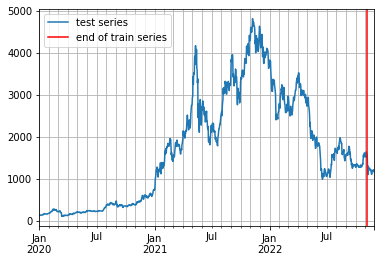

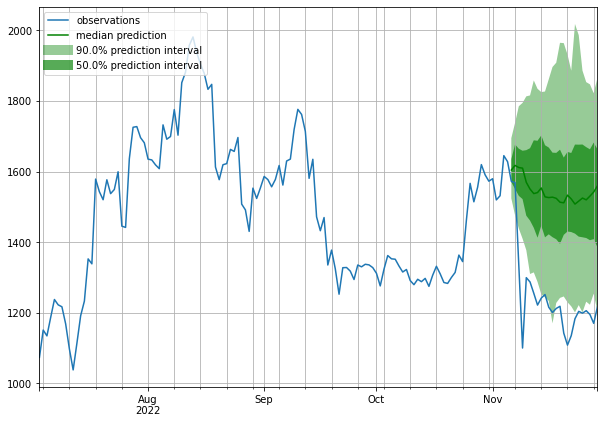

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]

{
    "MSE": 111909.45833333333,
    "abs_error": 7343.9169921875,
    "abs_target_sum": 29738.197265625,
    "abs_target_mean": 1239.091552734375,
    "seasonal_error": 61.759184762993264,
    "MASE": 4.954672612914769,
    "MAPE": 0.25476618607838947,
    "sMAPE": 0.22308039665222168,
    "MSIS": 25.63778948735985,
    "QuantileLoss[0.1]": 4640.347802734375,
    "Coverage[0.1]": 0.9166666666666666,
    "QuantileLoss[0.2]": 6867.781640625,
    "Coverage[0.2]": 0.9166666666666666,
    "QuantileLoss[0.3]": 7452.77158203125,
    "Coverage[0.3]": 0.9583333333333334,
    "QuantileLoss[0.4]": 7499.540917968749,
    "Coverage[0.4]": 1.0,
    "QuantileLoss[0.5]": 7343.916748046875,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.6]": 6596.50888671875,
    "Coverage[0.6]": 1.0,
    "QuantileLoss[0.7]": 5680.469311523439,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 4471.008349609374,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]": 2674.4399902343744,
    "Coverage[0.9]": 1.0,
    "RMSE"

In [70]:
mod_train(eth)

100%|██████████| 50/50 [00:04<00:00, 10.87it/s, epoch=500/500, avg_epoch_loss=2.7]


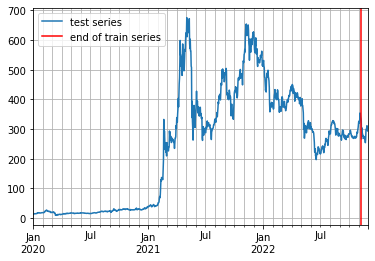

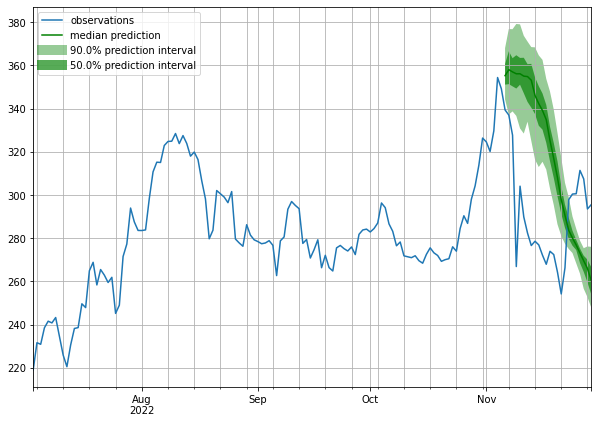

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


{
    "MSE": 2481.9440104166665,
    "abs_error": 1093.34326171875,
    "abs_target_sum": 6956.955078125,
    "abs_target_mean": 289.8731282552083,
    "seasonal_error": 8.749347705125121,
    "MASE": 5.206784639681865,
    "MAPE": 0.1612578829129537,
    "sMAPE": 0.14945732553799948,
    "MSIS": 108.71119199800559,
    "QuantileLoss[0.1]": 1177.5962036132814,
    "Coverage[0.1]": 0.7083333333333334,
    "QuantileLoss[0.2]": 1242.4743164062502,
    "Coverage[0.2]": 0.7083333333333334,
    "QuantileLoss[0.3]": 1237.976641845703,
    "Coverage[0.3]": 0.7083333333333334,
    "QuantileLoss[0.4]": 1180.7389343261718,
    "Coverage[0.4]": 0.7083333333333334,
    "QuantileLoss[0.5]": 1093.343276977539,
    "Coverage[0.5]": 0.7083333333333334,
    "QuantileLoss[0.6]": 979.9411376953126,
    "Coverage[0.6]": 0.7083333333333334,
    "QuantileLoss[0.7]": 843.3118377685548,
    "Coverage[0.7]": 0.7083333333333334,
    "QuantileLoss[0.8]": 682.1836486816405,
    "Coverage[0.8]": 0.7083333333333334,

In [71]:
mod_train(bnb)

100%|██████████| 50/50 [00:04<00:00, 11.25it/s, epoch=500/500, avg_epoch_loss=2.27]


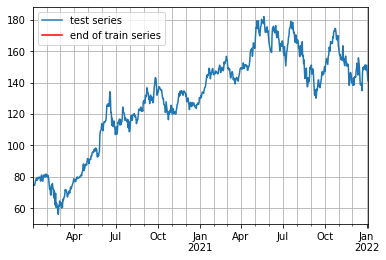

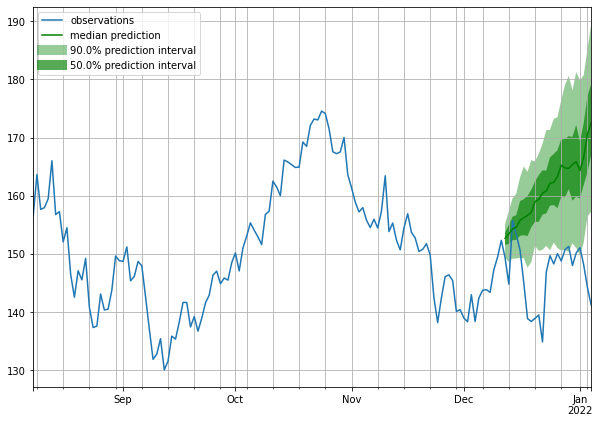

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]

{
    "MSE": 268.5171712239583,
    "abs_error": 353.29022216796875,
    "abs_target_sum": 3517.909912109375,
    "abs_target_mean": 146.57957967122397,
    "seasonal_error": 2.029199081011989,
    "MASE": 7.254303464559077,
    "MAPE": 0.1018536885579427,
    "sMAPE": 0.09572662909825642,
    "MSIS": 69.06767316757069,
    "QuantileLoss[0.1]": 313.3860626220703,
    "Coverage[0.1]": 0.9166666666666666,
    "QuantileLoss[0.2]": 382.03203125000005,
    "Coverage[0.2]": 0.9166666666666666,
    "QuantileLoss[0.3]": 391.7944061279296,
    "Coverage[0.3]": 0.9166666666666666,
    "QuantileLoss[0.4]": 378.053271484375,
    "Coverage[0.4]": 0.9583333333333334,
    "QuantileLoss[0.5]": 353.29022216796875,
    "Coverage[0.5]": 0.9583333333333334,
    "QuantileLoss[0.6]": 309.07427368164065,
    "Coverage[0.6]": 0.9583333333333334,
    "QuantileLoss[0.7]": 256.54096069335947,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 189.74571533203118,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]":

In [72]:
mod_train(aapl)

100%|██████████| 50/50 [00:04<00:00, 11.15it/s, epoch=500/500, avg_epoch_loss=2.46]


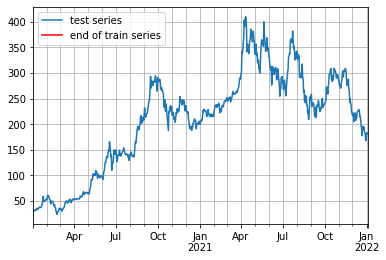

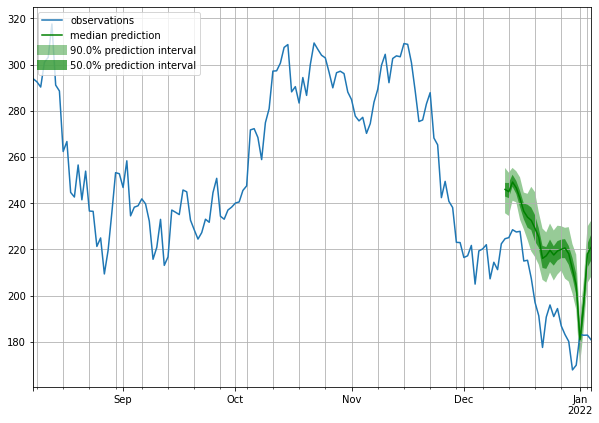

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]

{
    "MSE": 815.1856282552084,
    "abs_error": 644.196533203125,
    "abs_target_sum": 4727.27001953125,
    "abs_target_mean": 196.9695841471354,
    "seasonal_error": 6.199013520363188,
    "MASE": 4.329966716256538,
    "MAPE": 0.14028024673461914,
    "sMAPE": 0.1295914351940155,
    "MSIS": 95.27112555936272,
    "QuantileLoss[0.1]": 818.8527404785157,
    "Coverage[0.1]": 0.9583333333333334,
    "QuantileLoss[0.2]": 835.7813842773438,
    "Coverage[0.2]": 0.9583333333333334,
    "QuantileLoss[0.3]": 793.5940704345703,
    "Coverage[0.3]": 0.9583333333333334,
    "QuantileLoss[0.4]": 730.4133911132812,
    "Coverage[0.4]": 0.9583333333333334,
    "QuantileLoss[0.5]": 644.196533203125,
    "Coverage[0.5]": 0.9583333333333334,
    "QuantileLoss[0.6]": 540.6104248046876,
    "Coverage[0.6]": 0.9583333333333334,
    "QuantileLoss[0.7]": 430.41147766113284,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 308.69425048828117,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]": 167.68

In [73]:
mod_train(tsla)

100%|██████████| 50/50 [00:04<00:00, 11.17it/s, epoch=500/500, avg_epoch_loss=1.92]


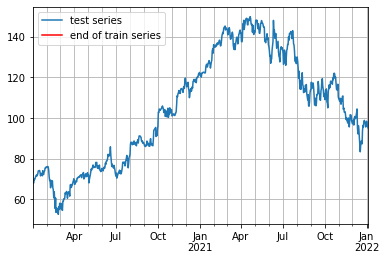

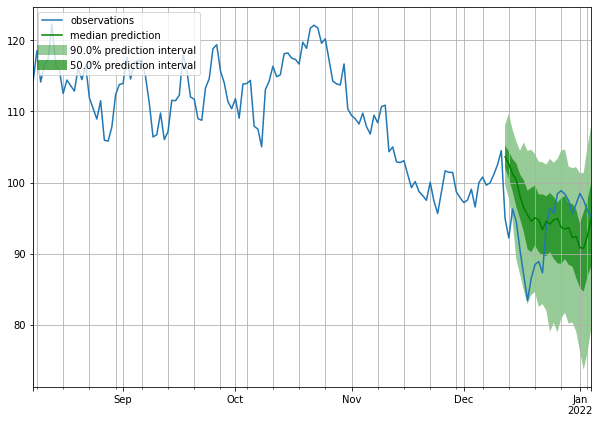

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

{
    "MSE": 42.383583068847656,
    "abs_error": 132.4417724609375,
    "abs_target_sum": 2249.0498046875,
    "abs_target_mean": 93.71040852864583,
    "seasonal_error": 1.5204623589562765,
    "MASE": 3.629427031433066,
    "MAPE": 0.059925819436709084,
    "sMAPE": 0.058651129404703774,
    "MSIS": 26.71901852962203,
    "QuantileLoss[0.1]": 71.07976837158203,
    "Coverage[0.1]": 0.25,
    "QuantileLoss[0.2]": 112.41426696777344,
    "Coverage[0.2]": 0.4166666666666667,
    "QuantileLoss[0.3]": 137.85868072509766,
    "Coverage[0.3]": 0.4583333333333333,
    "QuantileLoss[0.4]": 144.8631805419922,
    "Coverage[0.4]": 0.4583333333333333,
    "QuantileLoss[0.5]": 132.44176483154297,
    "Coverage[0.5]": 0.5,
    "QuantileLoss[0.6]": 119.41589965820313,
    "Coverage[0.6]": 0.5416666666666666,
    "QuantileLoss[0.7]": 96.24601135253907,
    "Coverage[0.7]": 0.7083333333333334,
    "QuantileLoss[0.8]": 66.54845886230468,
    "Coverage[0.8]": 0.875,
    "QuantileLoss[0.9]": 41.2292938

In [74]:
mod_train(googl)